# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

# from tensorflow.contrib.keras.python import keras
# from tensorflow.contrib.keras.python.keras import layers, models
# For tensorflow 1.4
from tensorflow.python import keras
from tensorflow.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm(input_layer=input_layer,
                                              filters=filters,
                                              strides=strides)
    
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    upsample = bilinear_upsample(input_layer=small_ip_layer)
    
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    skip_connect = layers.concatenate([upsample, large_ip_layer])
    
    # TODO Add some number of separable convolution layers
    output_layer = separable_conv2d_batchnorm(input_layer=skip_connect,
                                              filters=filters,
                                              strides=1)
    output_layer = separable_conv2d_batchnorm(input_layer=output_layer,
                                              filters=filters,
                                              strides=1)
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [48]:
def fcn_model(inputs, num_classes):
    
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    # Encode block
    enc_1 = encoder_block(input_layer=inputs,
                          filters=16,
                          strides=2) # 80x80
#     # 1x1 Conv
#     one_by_one_1 = conv2d_batchnorm(input_layer=enc_1,
#                                     filters=30,
#                                     kernel_size=1,
#                                     strides=1) # 80x80
    
    # Encode block
    enc_2 = encoder_block(input_layer=enc_1,
                          filters=32,
                          strides=2) # 40x40
    

    # 1x1 Conv
    one_by_one_2 = conv2d_batchnorm(input_layer=enc_2,
                                  filters=128,
                                  kernel_size=1,
                                  strides=1) # 40x40
    
    # Encode Block
    enc_3 = encoder_block(input_layer=one_by_one_2,
                          filters=64,
                          strides=2) # 20x20
    
    # Encode Block
    enc_4 = encoder_block(input_layer=enc_3,
                          filters=128,
                          strides=2) # 10x10
    
    # 1x1 Conv
    one_by_one_3 = conv2d_batchnorm(input_layer=enc_4,
                                  filters=170,
                                  kernel_size=1,
                                  strides=1) # 10x10
    
    # Decode block
    dec_1 = decoder_block(small_ip_layer=one_by_one_3,
                         large_ip_layer=enc_3,
                         filters=128) #20x20
    
    # Decode block
    dec_2 = decoder_block(small_ip_layer=dec_1,
                         large_ip_layer=enc_2,
                         filters=64) #40x40
    
    # Decode block
    dec_3 = decoder_block(small_ip_layer=dec_2,
                          large_ip_layer=enc_1,
                          filters=32) # 80x80
    
    # Decode block
    # Add the same number of Decoder Blocks as the number of Encoder Blocks
    x = decoder_block(small_ip_layer=dec_3,
                      large_ip_layer=inputs,
                      filters=16)
    
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(x)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [49]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [52]:
learning_rate = 0.1
batch_size = 32
num_epochs = 100
steps_per_epoch = 135 # orig: 200
validation_steps = 50
workers = 2

Epoch 1/100
134/135 [============================>.] - ETA: 0s - loss: 0.0288

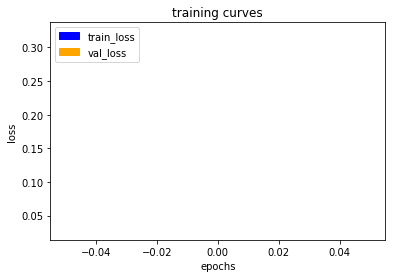

135/135 [==============================] - 88s - loss: 0.0288 - val_loss: 0.3225
Epoch 2/100
134/135 [============================>.] - ETA: 0s - loss: 0.0290

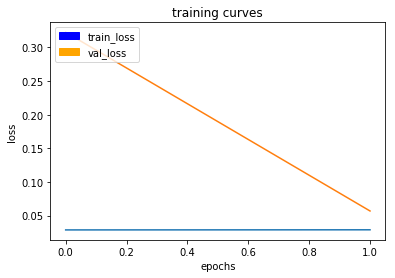

135/135 [==============================] - 87s - loss: 0.0290 - val_loss: 0.0569
Epoch 3/100
134/135 [============================>.] - ETA: 0s - loss: 0.0282

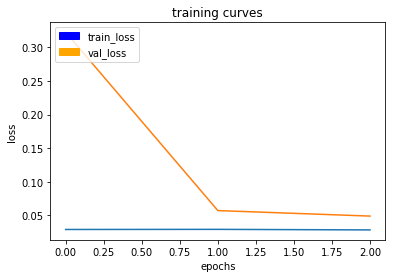

135/135 [==============================] - 87s - loss: 0.0282 - val_loss: 0.0488
Epoch 4/100
134/135 [============================>.] - ETA: 0s - loss: 0.0252

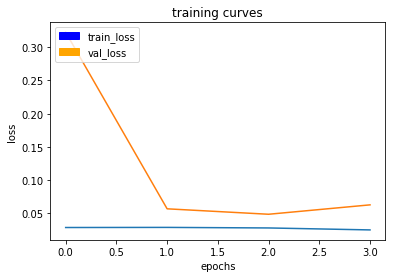

135/135 [==============================] - 87s - loss: 0.0252 - val_loss: 0.0629
Epoch 5/100
134/135 [============================>.] - ETA: 0s - loss: 0.0272

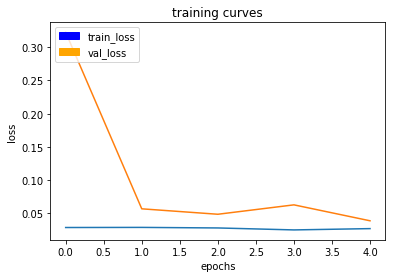

135/135 [==============================] - 87s - loss: 0.0271 - val_loss: 0.0389
Epoch 6/100
134/135 [============================>.] - ETA: 0s - loss: 0.0230

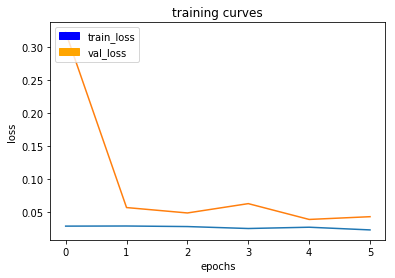

135/135 [==============================] - 87s - loss: 0.0231 - val_loss: 0.0431
Epoch 7/100
134/135 [============================>.] - ETA: 0s - loss: 0.0217

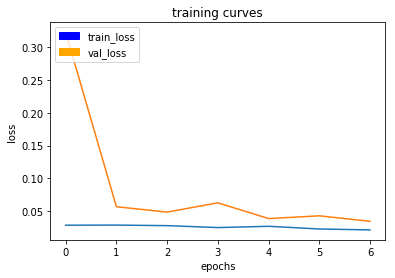

135/135 [==============================] - 87s - loss: 0.0216 - val_loss: 0.0348
Epoch 8/100
134/135 [============================>.] - ETA: 0s - loss: 0.0223

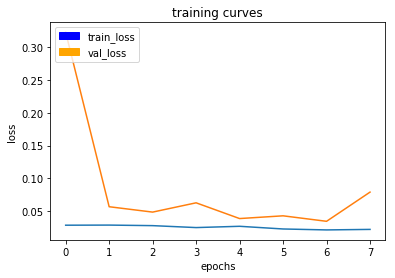

135/135 [==============================] - 87s - loss: 0.0224 - val_loss: 0.0792
Epoch 9/100
134/135 [============================>.] - ETA: 0s - loss: 0.0213

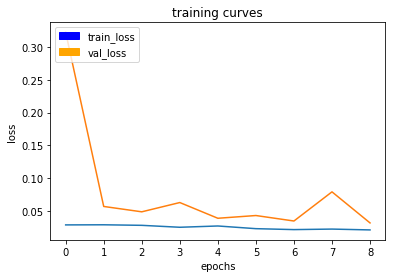

135/135 [==============================] - 87s - loss: 0.0212 - val_loss: 0.0318
Epoch 10/100
134/135 [============================>.] - ETA: 0s - loss: 0.0249

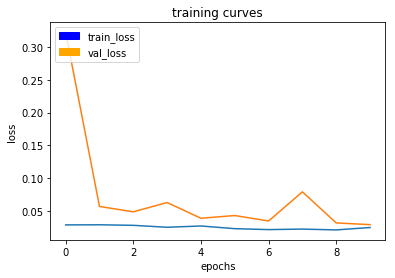

135/135 [==============================] - 87s - loss: 0.0248 - val_loss: 0.0292
Epoch 11/100
134/135 [============================>.] - ETA: 0s - loss: 0.0225

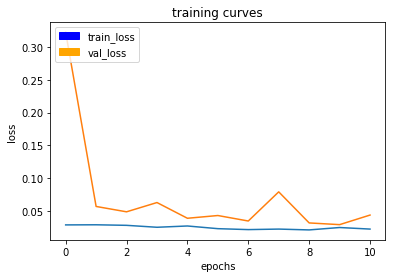

135/135 [==============================] - 87s - loss: 0.0224 - val_loss: 0.0438
Epoch 12/100
134/135 [============================>.] - ETA: 0s - loss: 0.0210

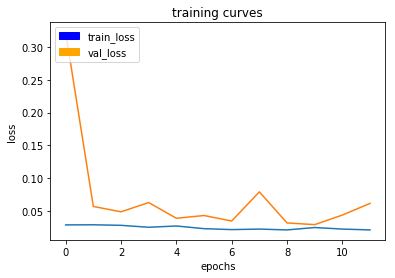

135/135 [==============================] - 87s - loss: 0.0212 - val_loss: 0.0616
Epoch 13/100
134/135 [============================>.] - ETA: 0s - loss: 0.0216

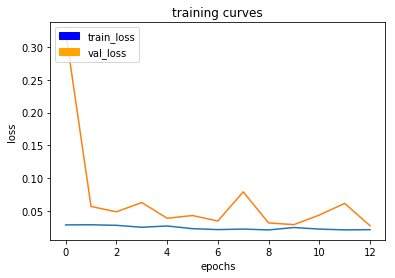

135/135 [==============================] - 87s - loss: 0.0216 - val_loss: 0.0275
Epoch 14/100
134/135 [============================>.] - ETA: 0s - loss: 0.0188

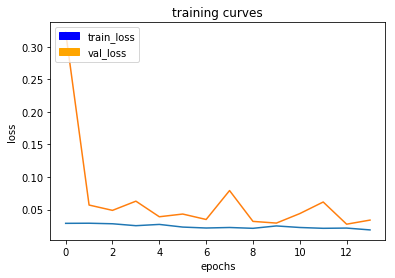

135/135 [==============================] - 87s - loss: 0.0188 - val_loss: 0.0338
Epoch 15/100
134/135 [============================>.] - ETA: 0s - loss: 0.0194

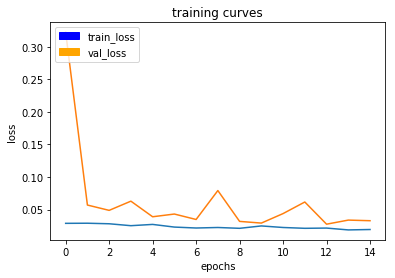

135/135 [==============================] - 87s - loss: 0.0193 - val_loss: 0.0329
Epoch 16/100
134/135 [============================>.] - ETA: 0s - loss: 0.0199

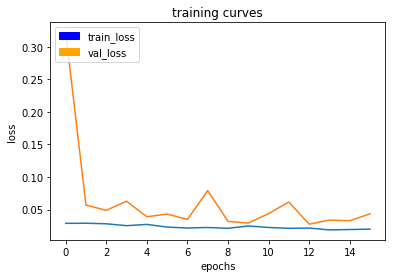

135/135 [==============================] - 87s - loss: 0.0199 - val_loss: 0.0434
Epoch 17/100
134/135 [============================>.] - ETA: 0s - loss: 0.0179

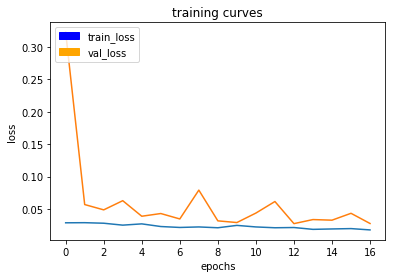

135/135 [==============================] - 87s - loss: 0.0178 - val_loss: 0.0278
Epoch 18/100
134/135 [============================>.] - ETA: 0s - loss: 0.0185

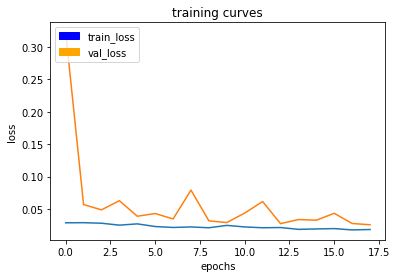

135/135 [==============================] - 87s - loss: 0.0185 - val_loss: 0.0258
Epoch 19/100
134/135 [============================>.] - ETA: 0s - loss: 0.0185

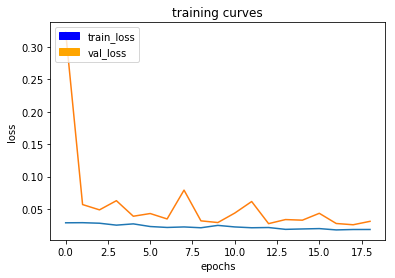

135/135 [==============================] - 87s - loss: 0.0185 - val_loss: 0.0311
Epoch 20/100
134/135 [============================>.] - ETA: 0s - loss: 0.0168

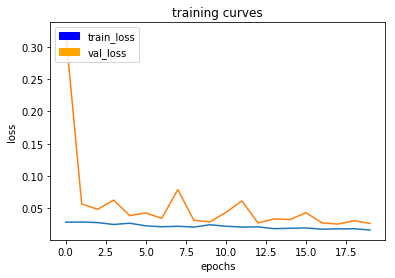

135/135 [==============================] - 87s - loss: 0.0168 - val_loss: 0.0268
Epoch 21/100
134/135 [============================>.] - ETA: 0s - loss: 0.0211

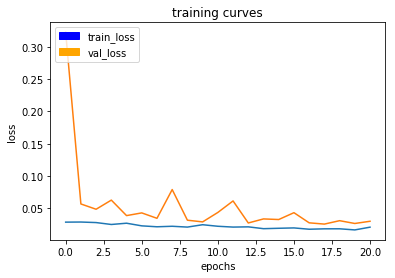

135/135 [==============================] - 87s - loss: 0.0210 - val_loss: 0.0302
Epoch 22/100
134/135 [============================>.] - ETA: 0s - loss: 0.0184

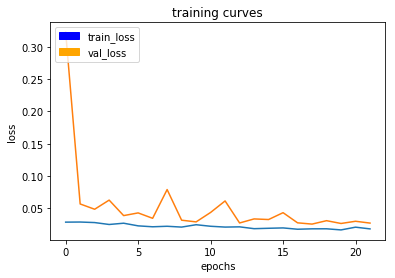

135/135 [==============================] - 87s - loss: 0.0184 - val_loss: 0.0273
Epoch 23/100
134/135 [============================>.] - ETA: 0s - loss: 0.0157

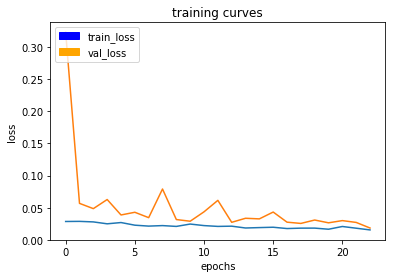

135/135 [==============================] - 87s - loss: 0.0157 - val_loss: 0.0187
Epoch 24/100
134/135 [============================>.] - ETA: 0s - loss: 0.0184

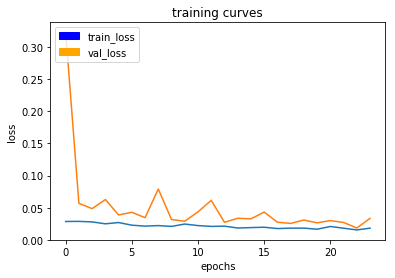

135/135 [==============================] - 87s - loss: 0.0184 - val_loss: 0.0336
Epoch 25/100
134/135 [============================>.] - ETA: 0s - loss: 0.0164

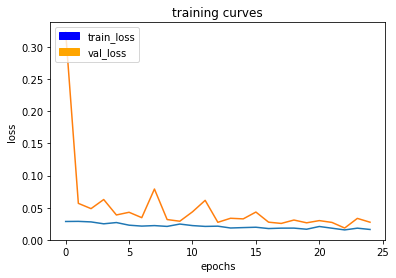

135/135 [==============================] - 87s - loss: 0.0164 - val_loss: 0.0277
Epoch 26/100
134/135 [============================>.] - ETA: 0s - loss: 0.0162

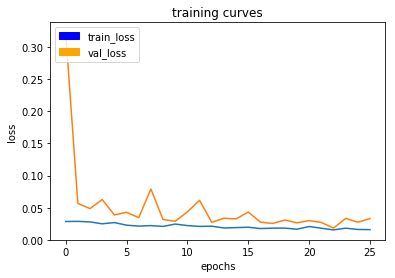

135/135 [==============================] - 87s - loss: 0.0162 - val_loss: 0.0334
Epoch 27/100
134/135 [============================>.] - ETA: 0s - loss: 0.0148

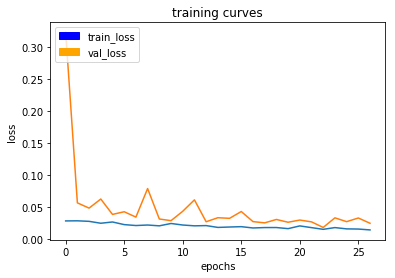

135/135 [==============================] - 87s - loss: 0.0148 - val_loss: 0.0252
Epoch 28/100
134/135 [============================>.] - ETA: 0s - loss: 0.0206

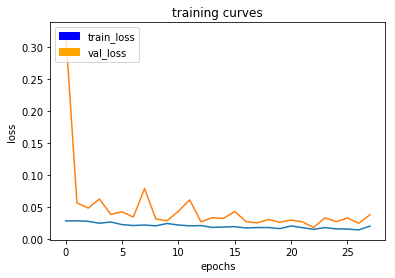

135/135 [==============================] - 87s - loss: 0.0207 - val_loss: 0.0385
Epoch 29/100
134/135 [============================>.] - ETA: 0s - loss: 0.0191

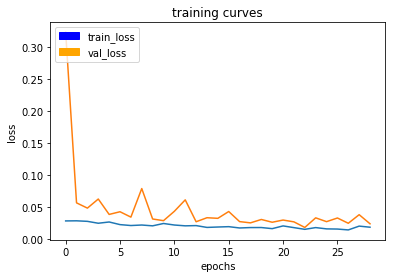

135/135 [==============================] - 87s - loss: 0.0191 - val_loss: 0.0243
Epoch 30/100
134/135 [============================>.] - ETA: 0s - loss: 0.0184

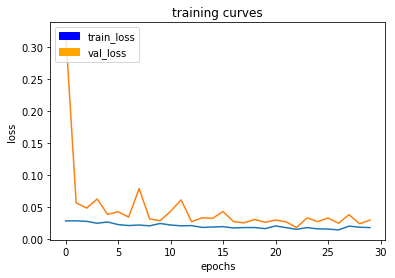

135/135 [==============================] - 87s - loss: 0.0184 - val_loss: 0.0302
Epoch 31/100
134/135 [============================>.] - ETA: 0s - loss: 0.0151

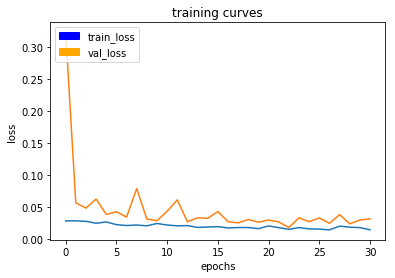

135/135 [==============================] - 87s - loss: 0.0151 - val_loss: 0.0321
Epoch 32/100
134/135 [============================>.] - ETA: 0s - loss: 0.0179

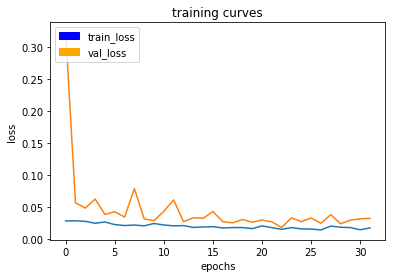

135/135 [==============================] - 87s - loss: 0.0179 - val_loss: 0.0328
Epoch 33/100
134/135 [============================>.] - ETA: 0s - loss: 0.0167

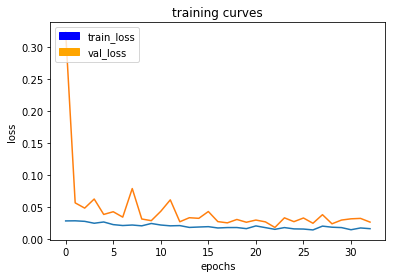

135/135 [==============================] - 87s - loss: 0.0167 - val_loss: 0.0270
Epoch 34/100
134/135 [============================>.] - ETA: 0s - loss: 0.0145

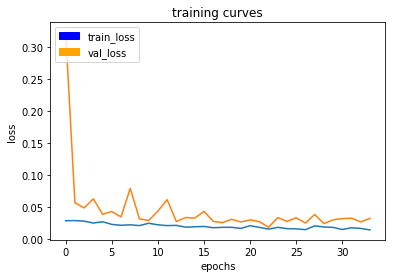

135/135 [==============================] - 87s - loss: 0.0145 - val_loss: 0.0325
Epoch 35/100
134/135 [============================>.] - ETA: 0s - loss: 0.0140

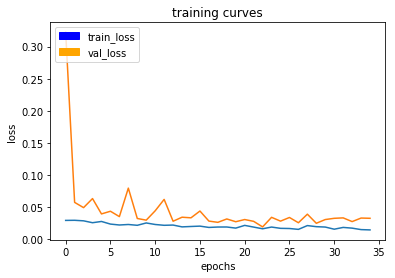

135/135 [==============================] - 87s - loss: 0.0140 - val_loss: 0.0321
Epoch 36/100
134/135 [============================>.] - ETA: 0s - loss: 0.0143

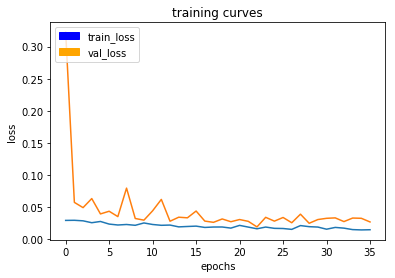

135/135 [==============================] - 87s - loss: 0.0143 - val_loss: 0.0264
Epoch 37/100
134/135 [============================>.] - ETA: 0s - loss: 0.0162

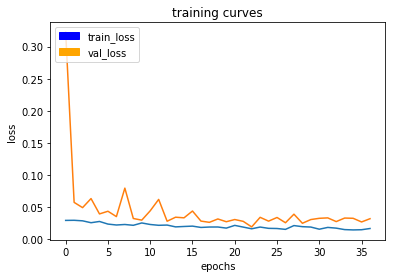

135/135 [==============================] - 87s - loss: 0.0162 - val_loss: 0.0315
Epoch 38/100
134/135 [============================>.] - ETA: 0s - loss: 0.0159

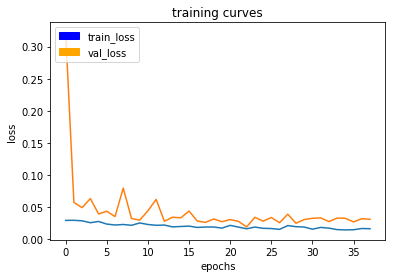

135/135 [==============================] - 87s - loss: 0.0158 - val_loss: 0.0306
Epoch 39/100
134/135 [============================>.] - ETA: 0s - loss: 0.0143

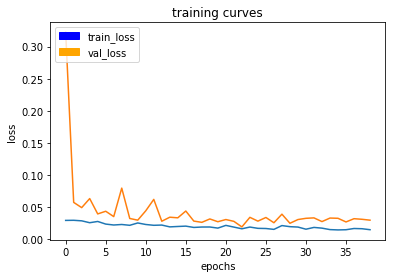

135/135 [==============================] - 87s - loss: 0.0143 - val_loss: 0.0292
Epoch 40/100
134/135 [============================>.] - ETA: 0s - loss: 0.0148

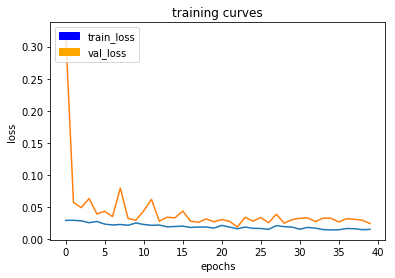

135/135 [==============================] - 87s - loss: 0.0148 - val_loss: 0.0239
Epoch 41/100
134/135 [============================>.] - ETA: 0s - loss: 0.0163

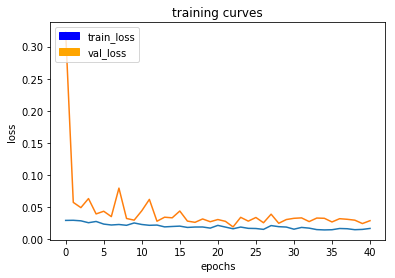

135/135 [==============================] - 87s - loss: 0.0163 - val_loss: 0.0284
Epoch 42/100
134/135 [============================>.] - ETA: 0s - loss: 0.0134

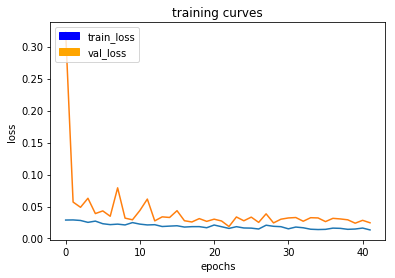

135/135 [==============================] - 87s - loss: 0.0134 - val_loss: 0.0245
Epoch 43/100
134/135 [============================>.] - ETA: 0s - loss: 0.0148

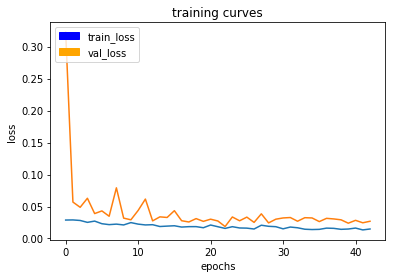

135/135 [==============================] - 87s - loss: 0.0148 - val_loss: 0.0269
Epoch 44/100
134/135 [============================>.] - ETA: 0s - loss: 0.0142

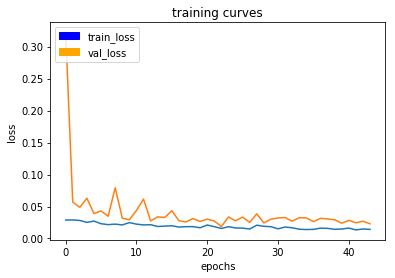

135/135 [==============================] - 86s - loss: 0.0142 - val_loss: 0.0230
Epoch 45/100
134/135 [============================>.] - ETA: 0s - loss: 0.0136

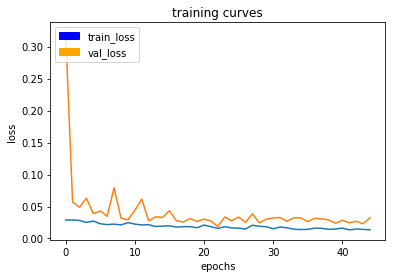

135/135 [==============================] - 87s - loss: 0.0136 - val_loss: 0.0324
Epoch 46/100
134/135 [============================>.] - ETA: 0s - loss: 0.0147

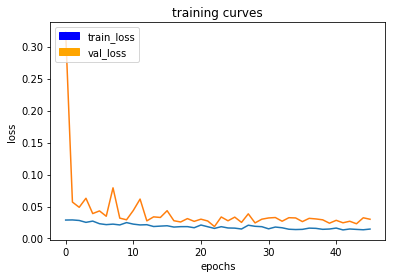

135/135 [==============================] - 87s - loss: 0.0147 - val_loss: 0.0301
Epoch 47/100
134/135 [============================>.] - ETA: 0s - loss: 0.0134

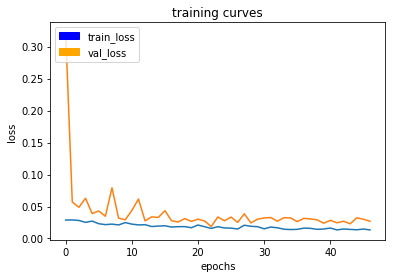

135/135 [==============================] - 87s - loss: 0.0134 - val_loss: 0.0270
Epoch 48/100
134/135 [============================>.] - ETA: 0s - loss: 0.0129

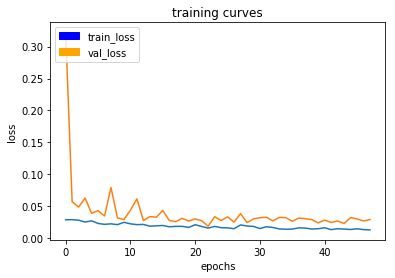

135/135 [==============================] - 87s - loss: 0.0129 - val_loss: 0.0292
Epoch 49/100
134/135 [============================>.] - ETA: 0s - loss: 0.0124

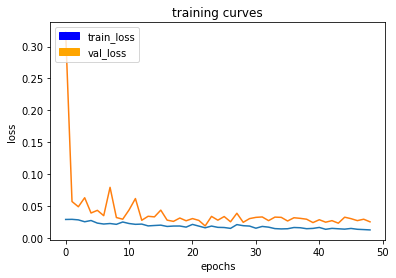

135/135 [==============================] - 87s - loss: 0.0124 - val_loss: 0.0251
Epoch 50/100
134/135 [============================>.] - ETA: 0s - loss: 0.0123

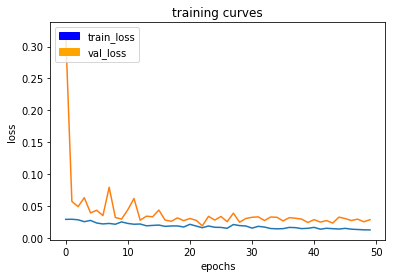

135/135 [==============================] - 87s - loss: 0.0123 - val_loss: 0.0283
Epoch 51/100
134/135 [============================>.] - ETA: 0s - loss: 0.0122

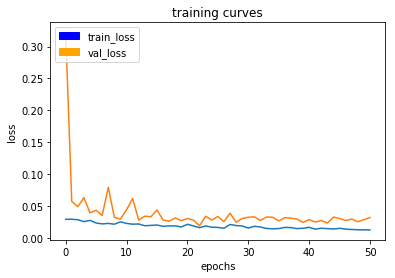

135/135 [==============================] - 87s - loss: 0.0122 - val_loss: 0.0317
Epoch 52/100
134/135 [============================>.] - ETA: 0s - loss: 0.0170

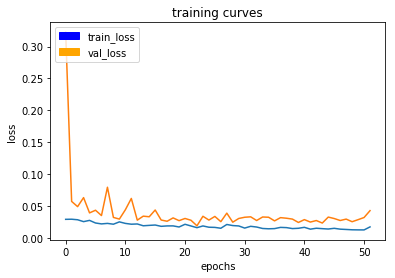

135/135 [==============================] - 87s - loss: 0.0169 - val_loss: 0.0425
Epoch 53/100
134/135 [============================>.] - ETA: 0s - loss: 0.0215

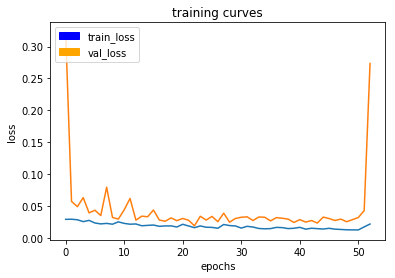

135/135 [==============================] - 87s - loss: 0.0215 - val_loss: 0.2734
Epoch 54/100
134/135 [============================>.] - ETA: 0s - loss: 0.0164

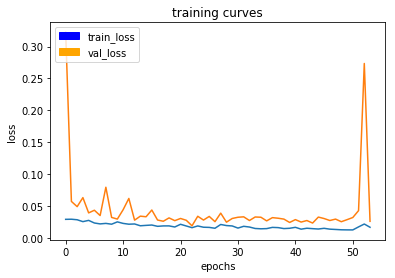

135/135 [==============================] - 87s - loss: 0.0164 - val_loss: 0.0257
Epoch 55/100
134/135 [============================>.] - ETA: 0s - loss: 0.0156

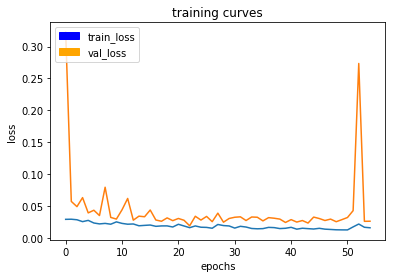

135/135 [==============================] - 87s - loss: 0.0156 - val_loss: 0.0259
Epoch 56/100
134/135 [============================>.] - ETA: 0s - loss: 0.0130

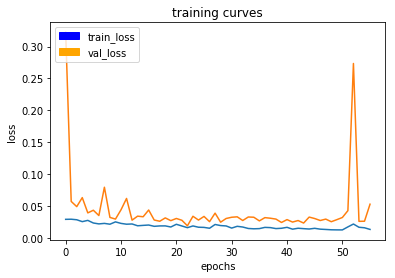

135/135 [==============================] - 87s - loss: 0.0130 - val_loss: 0.0526
Epoch 57/100
134/135 [============================>.] - ETA: 0s - loss: 0.0129

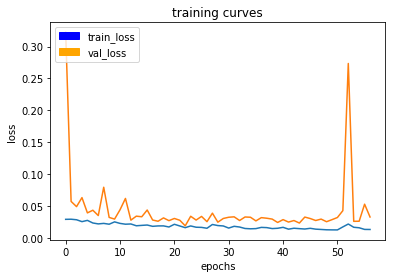

135/135 [==============================] - 87s - loss: 0.0129 - val_loss: 0.0325
Epoch 58/100
134/135 [============================>.] - ETA: 0s - loss: 0.0119

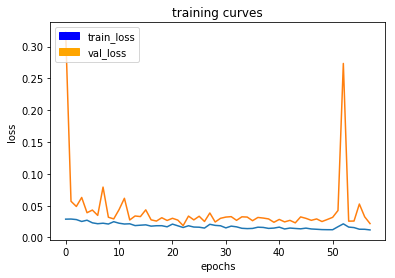

135/135 [==============================] - 87s - loss: 0.0119 - val_loss: 0.0218
Epoch 59/100
134/135 [============================>.] - ETA: 0s - loss: 0.0122

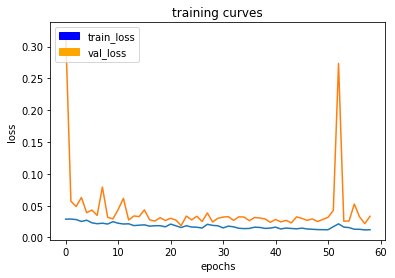

135/135 [==============================] - 87s - loss: 0.0122 - val_loss: 0.0333
Epoch 60/100
134/135 [============================>.] - ETA: 0s - loss: 0.0121

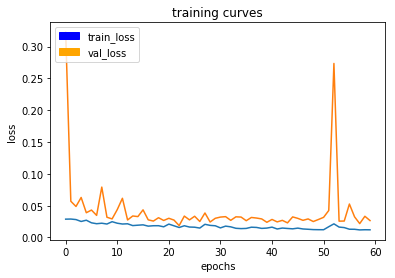

135/135 [==============================] - 87s - loss: 0.0121 - val_loss: 0.0266
Epoch 61/100
134/135 [============================>.] - ETA: 0s - loss: 0.0124

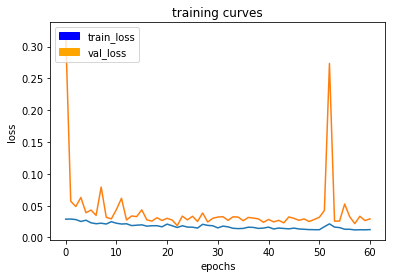

135/135 [==============================] - 87s - loss: 0.0124 - val_loss: 0.0293
Epoch 62/100
134/135 [============================>.] - ETA: 0s - loss: 0.0128

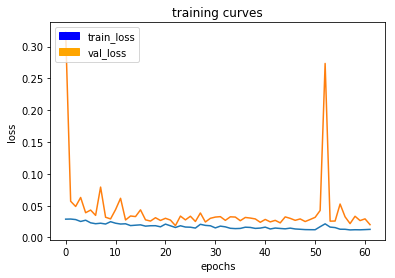

135/135 [==============================] - 87s - loss: 0.0128 - val_loss: 0.0202
Epoch 63/100
134/135 [============================>.] - ETA: 0s - loss: 0.0123

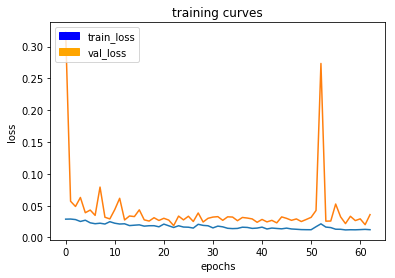

135/135 [==============================] - 87s - loss: 0.0123 - val_loss: 0.0359
Epoch 64/100
134/135 [============================>.] - ETA: 0s - loss: 0.0115

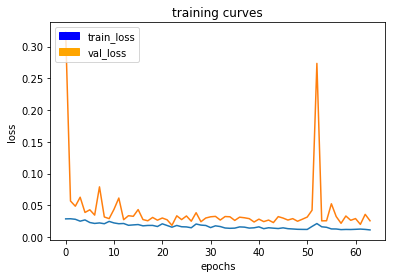

135/135 [==============================] - 87s - loss: 0.0114 - val_loss: 0.0258
Epoch 65/100
134/135 [============================>.] - ETA: 0s - loss: 0.0114

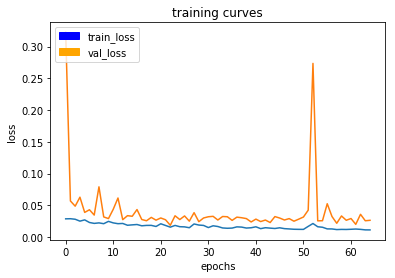

135/135 [==============================] - 87s - loss: 0.0114 - val_loss: 0.0265
Epoch 66/100
134/135 [============================>.] - ETA: 0s - loss: 0.0114

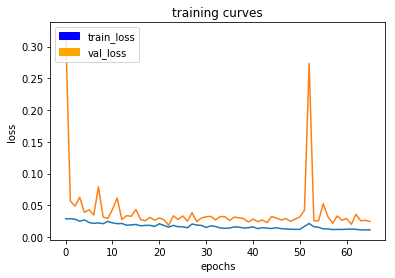

135/135 [==============================] - 87s - loss: 0.0115 - val_loss: 0.0246
Epoch 67/100
134/135 [============================>.] - ETA: 0s - loss: 0.0152

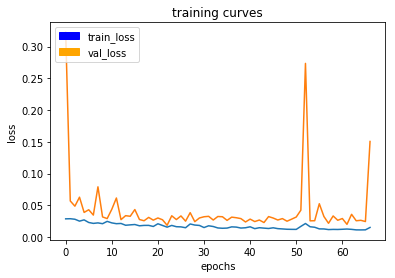

135/135 [==============================] - 87s - loss: 0.0153 - val_loss: 0.1506
Epoch 68/100
134/135 [============================>.] - ETA: 0s - loss: 0.0217

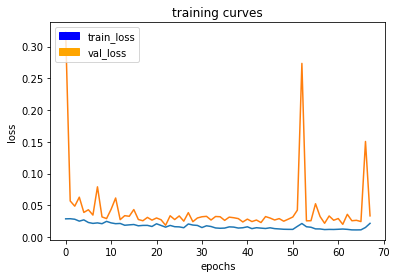

135/135 [==============================] - 87s - loss: 0.0217 - val_loss: 0.0335
Epoch 69/100
134/135 [============================>.] - ETA: 0s - loss: 0.0149

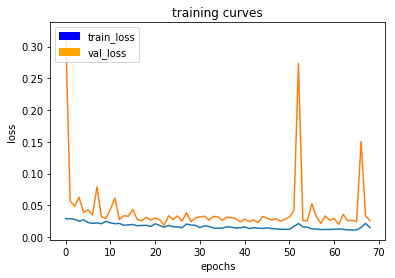

135/135 [==============================] - 87s - loss: 0.0149 - val_loss: 0.0257
Epoch 70/100
134/135 [============================>.] - ETA: 0s - loss: 0.0124

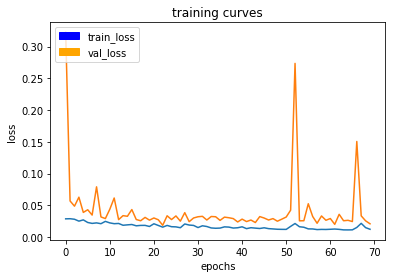

135/135 [==============================] - 87s - loss: 0.0124 - val_loss: 0.0210
Epoch 71/100
134/135 [============================>.] - ETA: 0s - loss: 0.0118

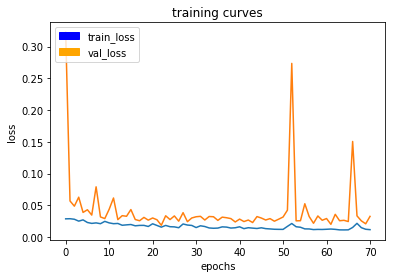

135/135 [==============================] - 87s - loss: 0.0118 - val_loss: 0.0327
Epoch 72/100
134/135 [============================>.] - ETA: 0s - loss: 0.0116

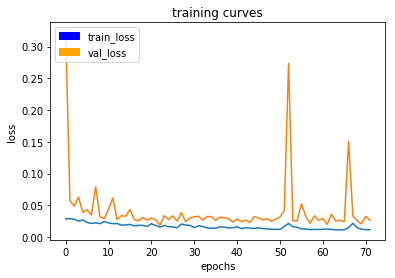

135/135 [==============================] - 87s - loss: 0.0116 - val_loss: 0.0266
Epoch 73/100
134/135 [============================>.] - ETA: 0s - loss: 0.0117

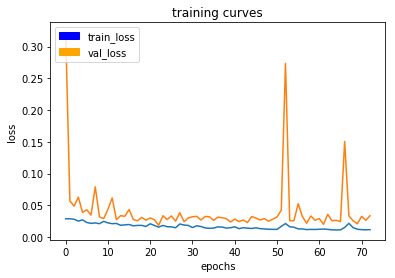

135/135 [==============================] - 87s - loss: 0.0117 - val_loss: 0.0337
Epoch 74/100
134/135 [============================>.] - ETA: 0s - loss: 0.0121

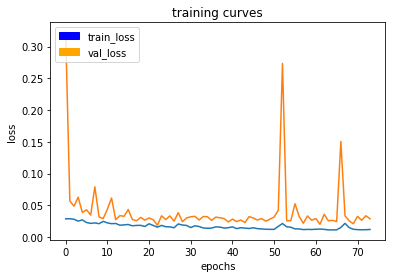

135/135 [==============================] - 87s - loss: 0.0121 - val_loss: 0.0289
Epoch 75/100
134/135 [============================>.] - ETA: 0s - loss: 0.0120

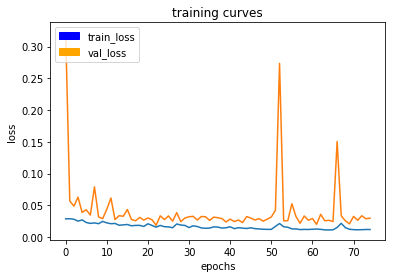

135/135 [==============================] - 87s - loss: 0.0120 - val_loss: 0.0299
Epoch 76/100
134/135 [============================>.] - ETA: 0s - loss: 0.0115

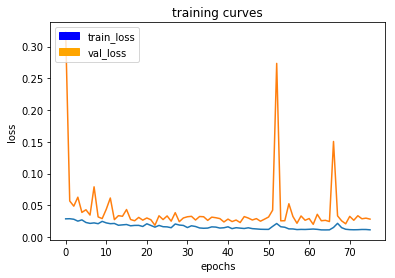

135/135 [==============================] - 87s - loss: 0.0115 - val_loss: 0.0284
Epoch 77/100
134/135 [============================>.] - ETA: 0s - loss: 0.0111

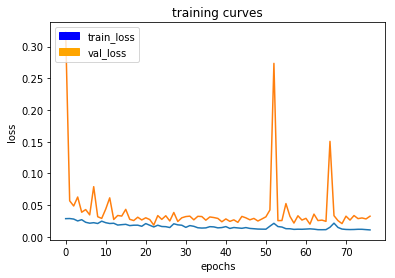

135/135 [==============================] - 87s - loss: 0.0111 - val_loss: 0.0327
Epoch 78/100
134/135 [============================>.] - ETA: 0s - loss: 0.0112

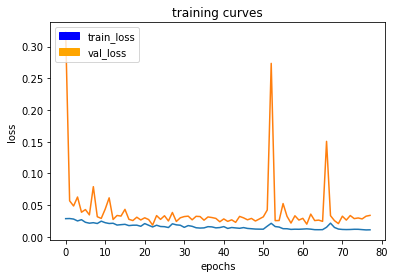

135/135 [==============================] - 87s - loss: 0.0112 - val_loss: 0.0340
Epoch 79/100
134/135 [============================>.] - ETA: 0s - loss: 0.0112

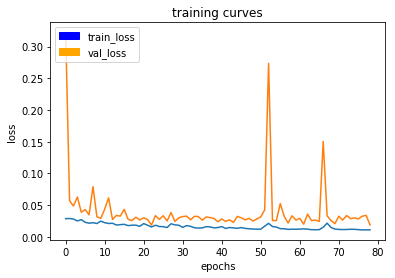

135/135 [==============================] - 87s - loss: 0.0112 - val_loss: 0.0190
Epoch 80/100
134/135 [============================>.] - ETA: 0s - loss: 0.0110

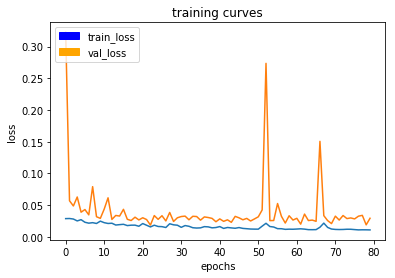

135/135 [==============================] - 88s - loss: 0.0110 - val_loss: 0.0294
Epoch 81/100
134/135 [============================>.] - ETA: 0s - loss: 0.0109

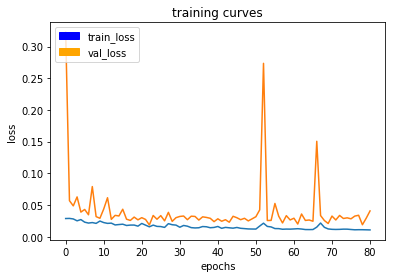

135/135 [==============================] - 87s - loss: 0.0109 - val_loss: 0.0408
Epoch 82/100
134/135 [============================>.] - ETA: 0s - loss: 0.0109

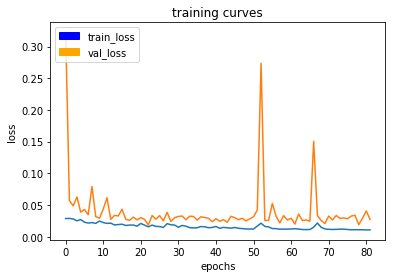

135/135 [==============================] - 87s - loss: 0.0109 - val_loss: 0.0274
Epoch 83/100
134/135 [============================>.] - ETA: 0s - loss: 0.0107

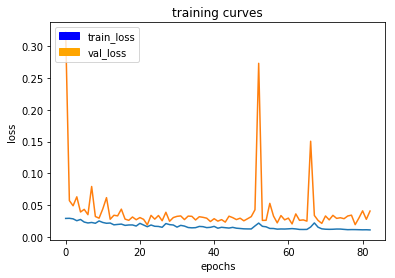

135/135 [==============================] - 87s - loss: 0.0107 - val_loss: 0.0404
Epoch 84/100
134/135 [============================>.] - ETA: 0s - loss: 0.0192

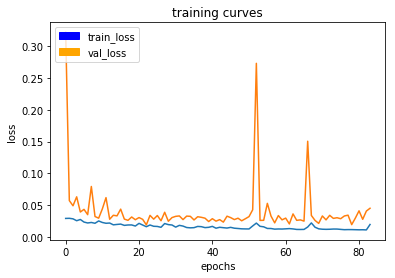

135/135 [==============================] - 87s - loss: 0.0192 - val_loss: 0.0448
Epoch 85/100
134/135 [============================>.] - ETA: 0s - loss: 0.0226

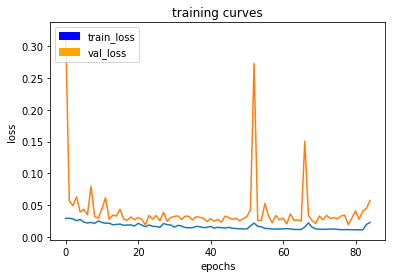

135/135 [==============================] - 87s - loss: 0.0226 - val_loss: 0.0570
Epoch 86/100
134/135 [============================>.] - ETA: 0s - loss: 0.0181

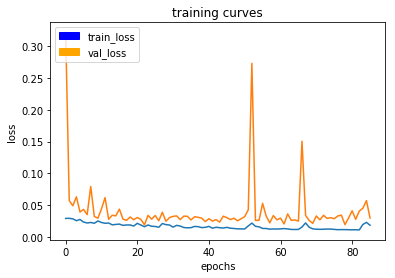

135/135 [==============================] - 87s - loss: 0.0181 - val_loss: 0.0294
Epoch 87/100
134/135 [============================>.] - ETA: 0s - loss: 0.0130

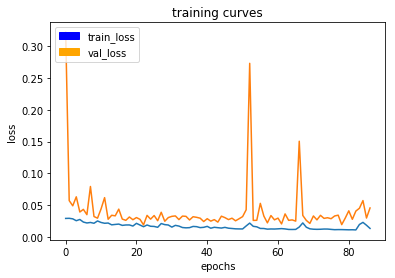

135/135 [==============================] - 87s - loss: 0.0131 - val_loss: 0.0453
Epoch 88/100
134/135 [============================>.] - ETA: 0s - loss: 0.0123

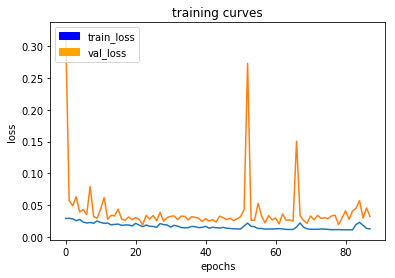

135/135 [==============================] - 86s - loss: 0.0123 - val_loss: 0.0319
Epoch 89/100
134/135 [============================>.] - ETA: 0s - loss: 0.0115

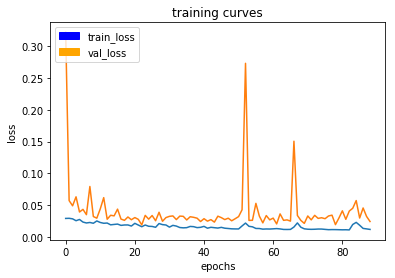

135/135 [==============================] - 87s - loss: 0.0115 - val_loss: 0.0239
Epoch 90/100
134/135 [============================>.] - ETA: 0s - loss: 0.0113

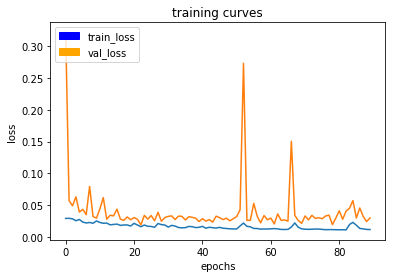

135/135 [==============================] - 87s - loss: 0.0113 - val_loss: 0.0296
Epoch 91/100
134/135 [============================>.] - ETA: 0s - loss: 0.0110

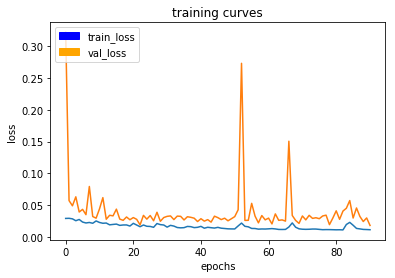

135/135 [==============================] - 87s - loss: 0.0110 - val_loss: 0.0177
Epoch 92/100
134/135 [============================>.] - ETA: 0s - loss: 0.0109

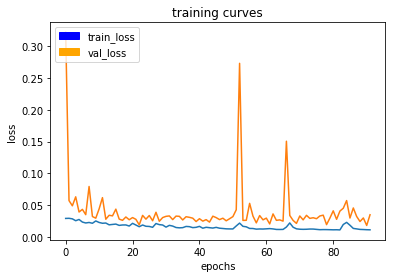

135/135 [==============================] - 87s - loss: 0.0109 - val_loss: 0.0346
Epoch 93/100
134/135 [============================>.] - ETA: 0s - loss: 0.0108

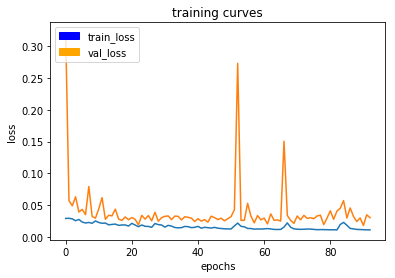

135/135 [==============================] - 87s - loss: 0.0108 - val_loss: 0.0300
Epoch 94/100
134/135 [============================>.] - ETA: 0s - loss: 0.0108

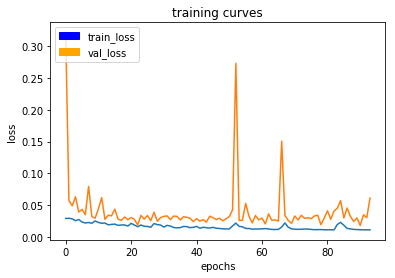

135/135 [==============================] - 87s - loss: 0.0108 - val_loss: 0.0610
Epoch 95/100
134/135 [============================>.] - ETA: 0s - loss: 0.0135

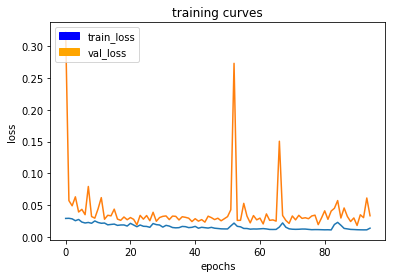

135/135 [==============================] - 87s - loss: 0.0134 - val_loss: 0.0330
Epoch 96/100
134/135 [============================>.] - ETA: 0s - loss: 0.0124

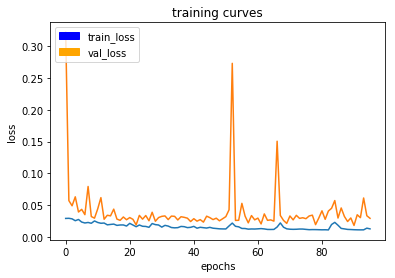

135/135 [==============================] - 87s - loss: 0.0123 - val_loss: 0.0290
Epoch 97/100
134/135 [============================>.] - ETA: 0s - loss: 0.0109

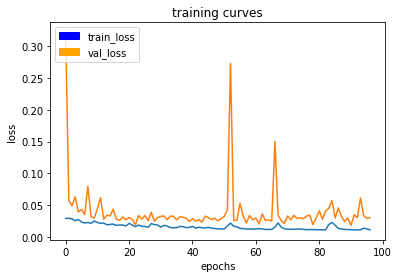

135/135 [==============================] - 87s - loss: 0.0109 - val_loss: 0.0301
Epoch 98/100
134/135 [============================>.] - ETA: 0s - loss: 0.0106

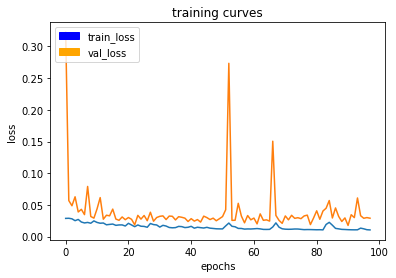

135/135 [==============================] - 87s - loss: 0.0106 - val_loss: 0.0291
Epoch 99/100
134/135 [============================>.] - ETA: 0s - loss: 0.0107

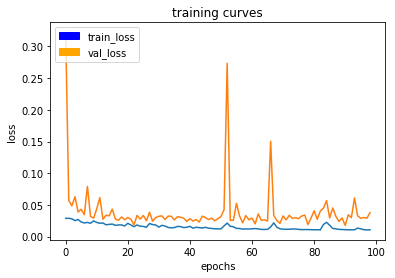

135/135 [==============================] - 87s - loss: 0.0107 - val_loss: 0.0379
Epoch 100/100
134/135 [============================>.] - ETA: 0s - loss: 0.0105

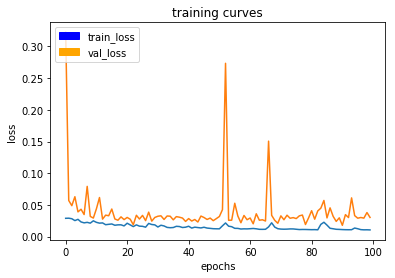

135/135 [==============================] - 87s - loss: 0.0105 - val_loss: 0.0302


In [53]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [ ]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [35]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [36]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

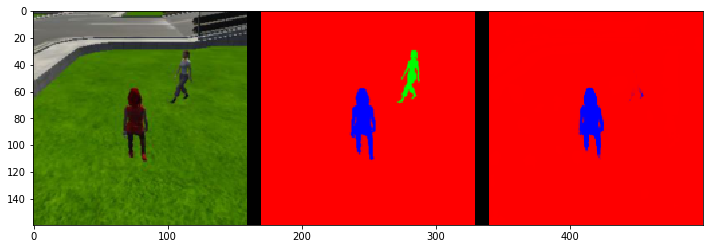

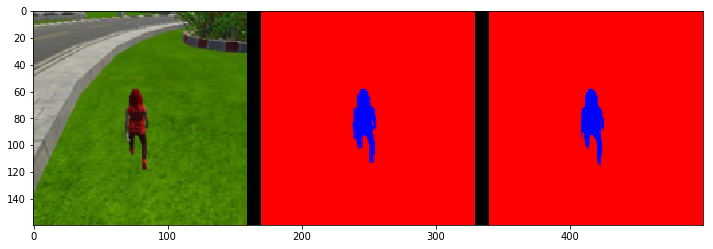

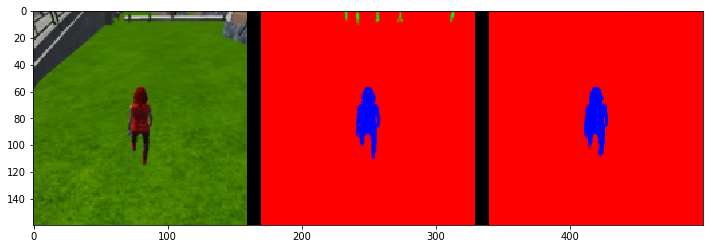

In [54]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

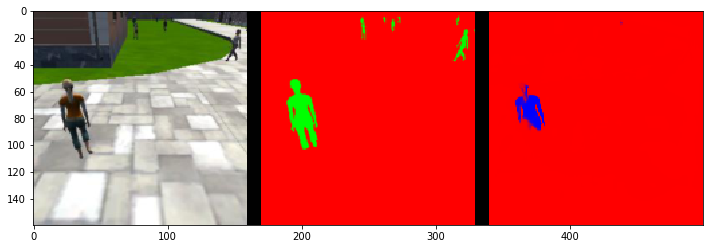

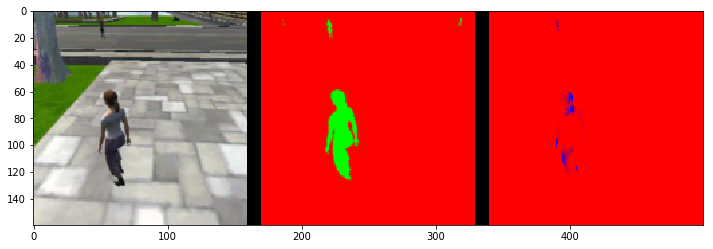

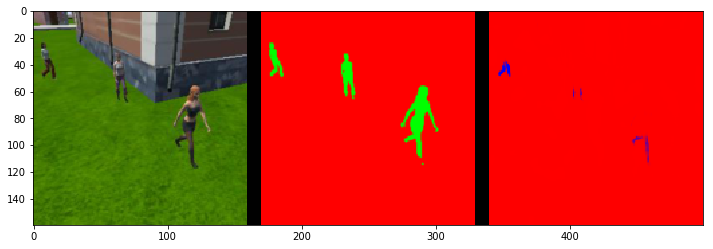

In [55]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

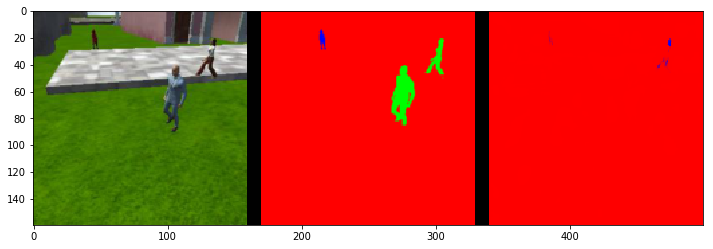

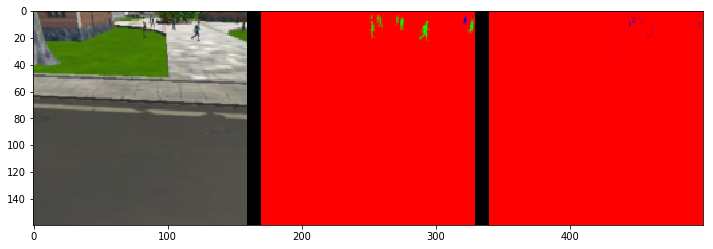

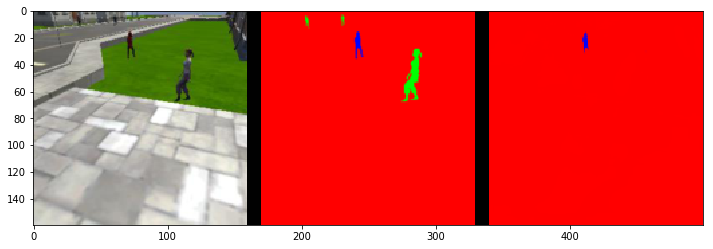

In [56]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [57]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9922883223210268
average intersection over union for other people is 0.0
average intersection over union for the hero is 0.9118396103756966
number true positives: 539, number false positives: 1, number false negatives: 0


In [58]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9580660963181812
average intersection over union for other people is 0.0
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 191, number false negatives: 0


In [59]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9920665907817589
average intersection over union for other people is 0.0
average intersection over union for the hero is 0.2656229780231501
number true positives: 211, number false positives: 9, number false negatives: 90


In [60]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7204610951008645


In [61]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.588731294199


In [62]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.424157992939
